In [27]:
import pandas as pd
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = 99
pd.options.display.max_rows = 999

In [28]:
frac = 0.02

In [29]:

aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]

radio_ref = pd.read_csv('./../data/info/radio_ref.csv')
# radio_ref[['PROV','NOMPROV','DPTO', 'NOMDPTO']].drop_duplicates().to_csv('./data/DPTO_PROV.csv', index = False)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
radio_ref = radio_ref[['RADIO_REF_ID', 'NOMDPTO', 'AGLOMERADO', 'Region']].drop_duplicates().merge(aglo_labels)


data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2019.csv')
data['Grupo Etario'] = pd.cut(data.P03, np.arange(-1, 80, 3))#.round(-1) ## Customizar grupo etario

data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'AGLOMERADO'])
data['AGLO_si'] = data.AGLOMERADO != 0

In [30]:
## Coversion a pesos de AGO 20, cuando fue elaborado el informe de INDEC
cpi = pd.read_csv('./../data/info/indice_precios_M.csv', index_col=0)
ix = cpi.loc['2021-01-31'].values[0]/cpi.loc['2020-08-31'].values[0]
ix

1.1584037876386652

## Caracteristicas Basicas
### Poblacion total

In [31]:
np.round(len(data)/frac/4, -5)

44200000.0

In [33]:
np.round(data.HOGAR_REF_ID.nunique()/frac, -5)

13400000.0

### Poblacion dentro y fuera de AGLOS

In [34]:

(data.groupby('AGLO_si').size()/frac/4).round(-5).astype(int)

AGLO_si
False    16400000
True     27800000
dtype: int32

In [35]:
(data.groupby('AGLO_si')['HOGAR_REF_ID'].nunique()/frac/4).round(-5).astype(int)

AGLO_si
False    1200000
True     2100000
Name: HOGAR_REF_ID, dtype: int32

### Poblacion en Pobreza

In [50]:
## Personas
### Cantidad
pob_cnt = (data.loc[data.AGLO_si].groupby(['Pobreza', 'Q']).size()/frac/4)
pob_cnt.round(-4).astype(int).unstack()

Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Pobreza,,,,
False,4230000,3880000,4200000,3780000
True,2710000,3060000,2740000,3160000


In [51]:
### Porcentaje
4*(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Pobreza,,,,
False,60.8,56.0,60.4,54.4
True,39.2,44.0,39.6,45.6


In [52]:
## Hogares
### Cantidad
pob_cnt = (data.loc[data.AGLO_si].groupby(['Pobreza', 'Q'])['HOGAR_REF_ID'].nunique()/frac/4)  ## ojo porque mal groupby Q suma hogares que puedieron ser pobres en distintos trimestres
pob_cnt.round(-4).astype(int).unstack()

Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Pobreza,,,,
False,1490000,1390000,1480000,1380000
True,640000,750000,650000,760000


In [53]:
### Porcentaje
4*(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Pobreza,,,,
False,70.0,64.8,69.2,64.4
True,30.0,35.2,30.8,35.6


#### Otras caracteristicas de hogares en pobreza

In [54]:
data_AGLO = data.loc[data.AGLO_si]

# Tamaño promedio del hogar
data_AGLO.loc[data_AGLO.Pobreza].groupby(['HOGAR_REF_ID', 'Q']).size().mean()

# df = pd.read_csv('./../data/training/EPHARG_train_20.csv')
# df.head()#.groupby(['CODUSU', 'TRIMESTRE']).size().mean()

4.164750052392907

In [55]:
# 'Ingreso total familiar promedio' y 'Canasta básica total promedio del hogar'
ITF = data_AGLO.loc[data_AGLO.Pobreza][['HOGAR_REF_ID', 'P47T_hogar', 'CBT']].drop_duplicates().drop('HOGAR_REF_ID', axis = 1).mean()
np.round(ITF/ix, -2)

# ITF_pond = data.loc[data.Pobreza].P47T_hogar.mean()
# np.round(ITF_pond/ix, -2)

P47T_hogar    34400.0
CBT           60200.0
dtype: float64

In [56]:
## Brecha
np.round(100*(ITF['CBT']/ITF['P47T_hogar'] - 1), 1)

## Descripcion Brecha
desc = data_AGLO.groupby(['Pobreza', 'Indigencia'])[['P47T_hogar', 'gap_pobreza', 'gap_indigencia']].describe().round(-2).astype(int)
desc.T.loc[desc.columns.get_level_values(1).isin(['mean', 'min', '25%', '50%', '75%', 'max'])].T

P47T_hogar                                          \
                         mean    min    25%     50%     75%       max   
Pobreza Indigencia                                                      
False   False          177900  13700  74400  106800  152200  18664500   
True    False           58000   6000  38800   53400   71500    571700   
        True            22300      0  11300   20700   31500    136300   

                   gap_pobreza                                         \
                          mean     min    25%    50%    75%       max   
Pobreza Indigencia                                                      
False   False            94700       0  18800  42300  81900  12078800   
True    False           -26000 -256800 -36700 -21900 -10500         0   
        True            -67900 -391500 -83000 -62600 -46200     -7800   

                   gap_indigencia                                          
                             mean     min    25%    50%     75%       max  
Pobreza Indigencia                                                         
False   False              144300    7700  53400  80400  122700  16012500  
True    False               24100       0  10500  20900   34000    337600  
        True               -14300 -143100 -20600 -11900   -5300         0

### Poblacion en Indigencia

In [63]:
## Personas
### Cantidad
pob_cnt = (data.loc[data.AGLO_si].groupby(['Indigencia', 'Q']).size()/frac/4)
pob_cnt.round(-4).astype(int).unstack()

Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Indigencia,,,,
False,6140000,6130000,6120000,6030000
True,800000,810000,820000,910000


In [58]:
### Porcentaje
(100*pob_cnt/pob_cnt.sum()).round(1)

Indigencia
False    88.0
True     12.0
dtype: float64

In [61]:
## Hogares
### Cantidad
pob_cnt = data.loc[data.AGLO_si].groupby(['Indigencia', 'Q'])['HOGAR_REF_ID'].nunique()/frac

pob_cnt.round(-4).astype(int).unstack()

Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Indigencia,,,,
False,7800000,7780000,7780000,7720000
True,730000,750000,750000,820000


In [65]:
### Porcentaje
(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Indigencia,,,,
False,22.1,22.1,22.1,21.7
True,2.9,2.9,2.9,3.3


#### Otras caracteristicas de hogares en indigencia

In [67]:
data_AGLO = data.loc[data.AGLO_si]

# Tamaño promedio del hogar
data_AGLO.loc[data_AGLO.Indigencia].groupby(['HOGAR_REF_ID', 'Q']).size().mean()

# df = pd.read_csv('./../data/training/EPHARG_train_20.csv')
# df.head()#.groupby(['CODUSU', 'TRIMESTRE']).size().mean()

4.360724552463086

In [68]:
# 'Ingreso total familiar promedio' y 'Canasta básica total promedio del hogar'
ITF = data_AGLO.loc[data_AGLO.Indigencia][['HOGAR_REF_ID', 'P47T_hogar', 'CBA']].drop_duplicates().drop('HOGAR_REF_ID', axis = 1).mean()
np.round(ITF/ix, -2)

# ITF_pond = data.loc[data.Pobreza].P47T_hogar.mean()
# np.round(ITF_pond/ix, -2)

P47T_hogar    15300.0
CBA           25600.0
dtype: float64

## Pobres no indigentes, y no pobres.

In [72]:
data_AGLO = data.loc[data.AGLO_si]

## Personas
### Cantidad
pob_cnt = data_AGLO.groupby(['Pobreza', 'Indigencia', 'Q']).size()/frac
pob_cnt.round(-4).astype(int).unstack()

Q                   2019-03-31  2019-06-30  2019-09-30  2019-12-31
Pobreza Indigencia                                                
False   False         16940000    15520000    16790000    15110000
True    False          7630000     8990000     7700000     9030000
        True           3200000     3260000     3270000     3630000

In [75]:
### Porcentaje
4*(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q                   2019-03-31  2019-06-30  2019-09-30  2019-12-31
Pobreza Indigencia                                                
False   False             60.8        56.0        60.4        54.4
True    False             27.6        32.4        27.6        32.4
        True              11.6        11.6        11.6        13.2

In [77]:
## Hogares
### Cantidad
pob_cnt = data_AGLO.groupby(['Pobreza', 'Indigencia', 'Q'])['HOGAR_REF_ID'].nunique()/frac
pob_cnt.round(-4).astype(int).unstack()

Q                   2019-03-31  2019-06-30  2019-09-30  2019-12-31
Pobreza Indigencia                                                
False   False          5960000     5540000     5920000     5500000
True    False          1840000     2240000     1860000     2210000
        True            730000      750000      750000      820000

In [79]:
### Porcentaje
4*(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q                   2019-03-31  2019-06-30  2019-09-30  2019-12-31
Pobreza Indigencia                                                
False   False             70.0        64.8        69.2        64.4
True    False             21.6        26.4        22.0        26.0
        True               8.4         8.8         8.8         9.6

## Por grupo etario

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
info = 100*data.groupby(['Grupo Etario'])[['Pobreza', 'Indigencia']].sum().div(data.groupby(['Grupo Etario']).size(), 0)

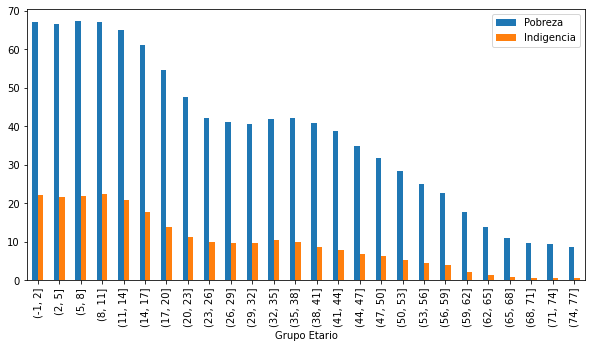

In [30]:
info.plot(kind = 'bar', figsize = (10, 5))
plt.show()

## Geografica

In [31]:
data_AGLO = data.loc[data.AGLO_si].reset_index().rename(columns = {'index': 'PERSONA_ID'})

In [32]:
info_ARG = data_AGLO.groupby(['Pobreza','Indigencia'])[['HOGAR_REF_ID', 'PERSONA_ID']].nunique()
(100*info_ARG/info_ARG.sum()).round(1)

HOGAR_REF_ID  PERSONA_ID
Pobreza Indigencia                          
False   False               70.7        60.7
True    False               22.6        29.9
        True                 6.8         9.4

### Por regiones

In [33]:
info_ARG = data_AGLO.groupby(['Region', 'Pobreza','Indigencia'])[['HOGAR_REF_ID', 'PERSONA_ID']].nunique()

# Hogares
cuadro_H = (100*info_ARG.unstack([-2, -1]).div(data_AGLO.groupby('Region')['HOGAR_REF_ID'].nunique(), 0)).round(1)['HOGAR_REF_ID']
cuadro_H

Pobreza           False True       
Indigencia        False False True 
Region                             
Cuyo               64.4  28.2   7.4
Gran Buenos Aires  73.1  21.0   6.0
Noreste            60.4  28.3  11.2
Noroeste           63.7  26.1  10.2
Pampeana           70.4  22.8   6.8
Patagónica         76.2  19.9   3.9

In [34]:
# Personas
cuadro_P = (100*info_ARG.unstack([-2, -1]).div(data_AGLO.groupby('Region')['PERSONA_ID'].nunique(), 0)).round(1)['PERSONA_ID']
cuadro_P


Pobreza           False True       
Indigencia        False False True 
Region                             
Cuyo               55.8  34.8   9.3
Gran Buenos Aires  63.1  28.5   8.4
Noreste            50.6  34.8  14.6
Noroeste           55.1  31.8  13.1
Pampeana           60.1  30.3   9.6
Patagónica         68.4  26.5   5.1

### Por Aglomerados

In [35]:
info_ARG = data_AGLO.groupby(['Region', 'NOMAGLO', 'Pobreza','Indigencia'])[['HOGAR_REF_ID', 'PERSONA_ID']].nunique()

# Hogares
cuadro_H = (100*info_ARG.unstack([-2, -1]).div(data_AGLO.groupby(['Region', 'NOMAGLO'])['HOGAR_REF_ID'].nunique(), 0)).round(1)['HOGAR_REF_ID']
pob_data = cuadro_H.T.loc[cuadro_H.columns.get_level_values('Pobreza')].T.sum(1)
cuadro_H = pd.concat([cuadro_H, pob_data], axis = 1)
cuadro_H.columns = ['No Pobres', 'Pobres no I.', 'Indigentes', 'Pobres']

cuadro_H.head()

No Pobres  Pobres no I.  Indigentes  Pobres
Region            NOMAGLO                                              
Cuyo              La Rioja       56.8          34.3         8.8    43.1
                  Mendoza        68.1          26.2         5.7    31.9
                  San Juan       59.5          29.7        10.8    40.5
                  San Luis       63.3          28.9         7.8    36.7
Gran Buenos Aires CABA           89.2           8.4         2.5    10.9

In [36]:
# Personas
info_ARG = data_AGLO.groupby(['Region', 'NOMAGLO', 'Pobreza','Indigencia'])[['HOGAR_REF_ID', 'PERSONA_ID']].nunique()

# Hogares
cuadro_P = (100*info_ARG.unstack([-2, -1]).div(data_AGLO.groupby(['Region', 'NOMAGLO'])['PERSONA_ID'].nunique(), 0)).round(1)['PERSONA_ID']

pob_data = cuadro_P.T.loc[cuadro_P.columns.get_level_values('Pobreza')].T.sum(1)
cuadro_P = pd.concat([cuadro_P, pob_data], axis = 1)
cuadro_P.columns = ['No Pobres', 'Pobres no I.', 'Indigentes', 'Pobres']

cuadro_P.head()

No Pobres  Pobres no I.  Indigentes  Pobres
Region            NOMAGLO                                              
Cuyo              La Rioja       48.2          41.1        10.7    51.8
                  Mendoza        58.9          33.8         7.3    41.1
                  San Juan       54.0          33.0        13.0    46.0
                  San Luis       52.1          38.1         9.7    47.8
Gran Buenos Aires CABA           84.5          12.1         3.4    15.5

In [1]:
pd.concat([cuadro_H[['Pobres']], cuadro_P[['Pobres']], 
          cuadro_H[['Indigentes']], cuadro_P[['Indigentes']]], axis = 1).round().astype(int)

NameError: name 'pd' is not defined

Pobres  Pobres  Indigentes  Indigentes
Region            NOMAGLO                                                   
Cuyo              La Rioja                43      52           9          11
                  Mendoza                 32      41           6           7
                  San Juan                40      46          11          13
                  San Luis                37      48           8          10
Gran Buenos Aires CABA                    11      16           2           3
                  GBA                     33      42           7          10
Noreste           Corrientes              39      48          11          14
                  Formosa                 42      51          11          13
                  Posadas                 37      48          11          15
                  Resistencia             41      51          12          15
Noroeste          Catamarca               33      43           8          11
                  Jujuy                   36      44          10          13
                  Salta                   36      44          10          13
                  Sgo del Estero          39      47          10          13
                  Tucuman                 36      45          11          14
Pampeana          Bahia Blanca            22      31           4           6
                  Concordia               42      54          13          19
                  Cordoba                 30      40           7          10
                  GBA                     42      53          10          13
                  La Plata                22      31           4           6
                  Mar del Plata           25      35           5           6
                  Parana                  30      39           7           9
                  Rio Cuarto              30      39           6           7
                  Rosario                 29      40           7          10
                  San Nicolas             33      43           8          11
                  Santa Fe                30      41           8          12
                  Santa Rosa              24      34           5           7
                  Viedma-Patagones        30      41           5           7
Patagónica        Cdro Rivadavia          24      31           4           6
                  Neuquen                 25      33           4           5
                  Rawson-Trelew           26      34           5           6
                  Rio Gallegos            22      31           3           5
                  Ushuaia-Rio Grande      19      26           2           2
                  Viedma-Patagones        23      35           8          12

In [38]:
# pobres_CABA = data.loc[(data.PROV == 2) & (data.Pobreza)].groupby(['DPTO', 'IDFRAC']).size().sort_values(ascending = False)/frac
# i = ((pobres_CABA/pobres_CABA.sum()).cumsum() < .9).sum()
# pd.DataFrame(pobres_CABA.iloc[:i])#.sort_index()